# Importação das bibliotecas 
1. Pytorch -> Lib para trabalhar com redes neurais. Nesse caso, convolucionais pois estamos trabalhando com imagens (passar em um kernel ou algo do tipo).
2. NumPy -> Operações com matrizes e AL.
3. Matplotlib e seaborn -> Visualização dos resultados e plots de imagens

In [71]:
import torch # nn basico
import torchvision # dataset, transformações e modelos para tasks de Visão Compt.
import torch.optim as optim # otimizadores, tipo o ADAM
import torch.nn as nn # Conv2D, Linear...
import torch.utils.data as data # carregar os dados e manipulação
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, f1_score # metricas

import numpy as np # expliquei acima markdown

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt # expliquei acima markdown
import seaborn as sns # expliquei acima markdown

In [2]:
# Configurações básicas

config = {"num_epochs" : 20, # epocas 
"batch_size" : 100, # tam do batch
"learning_rate":  0.001} # taxa de aprendizado
config

{'num_epochs': 20, 'batch_size': 100, 'learning_rate': 0.001}

In [3]:
def train_val_split(dataset, val_ratio=0.2, ):
    num_samples = len(dataset)
    num_val = int(num_samples * val_ratio)
    num_train = num_samples - num_val
    trainset, valset = torch.utils.data.random_split(dataset, [num_train, num_val])
    return trainset, valset

In [4]:
# normalização dos dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normalização para dados de imagem
])

train_val = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Conjuntos de dados
trainset, valset = train_val_split(train_val,0.2)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.57MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
display(len(trainset), len(valset),len(testset))

48000

12000

10000

Pela saída acima, vimos que o conjunto de treinamento tem 48 mil dados, val tem 12 mil e o conjunto de teste tem 10 mil

In [60]:
def display_dataset_examples(dataset, num_examples=5):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    fig, axs = plt.subplots(1, num_examples, figsize=(20, 5))
    for i in range(num_examples):
        axs[i].imshow(dataset[i][0].squeeze(), cmap='gray')
        axs[i].set_title(f'Label: {class_names[dataset[i][1]]}', rotation=45, ha='center')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

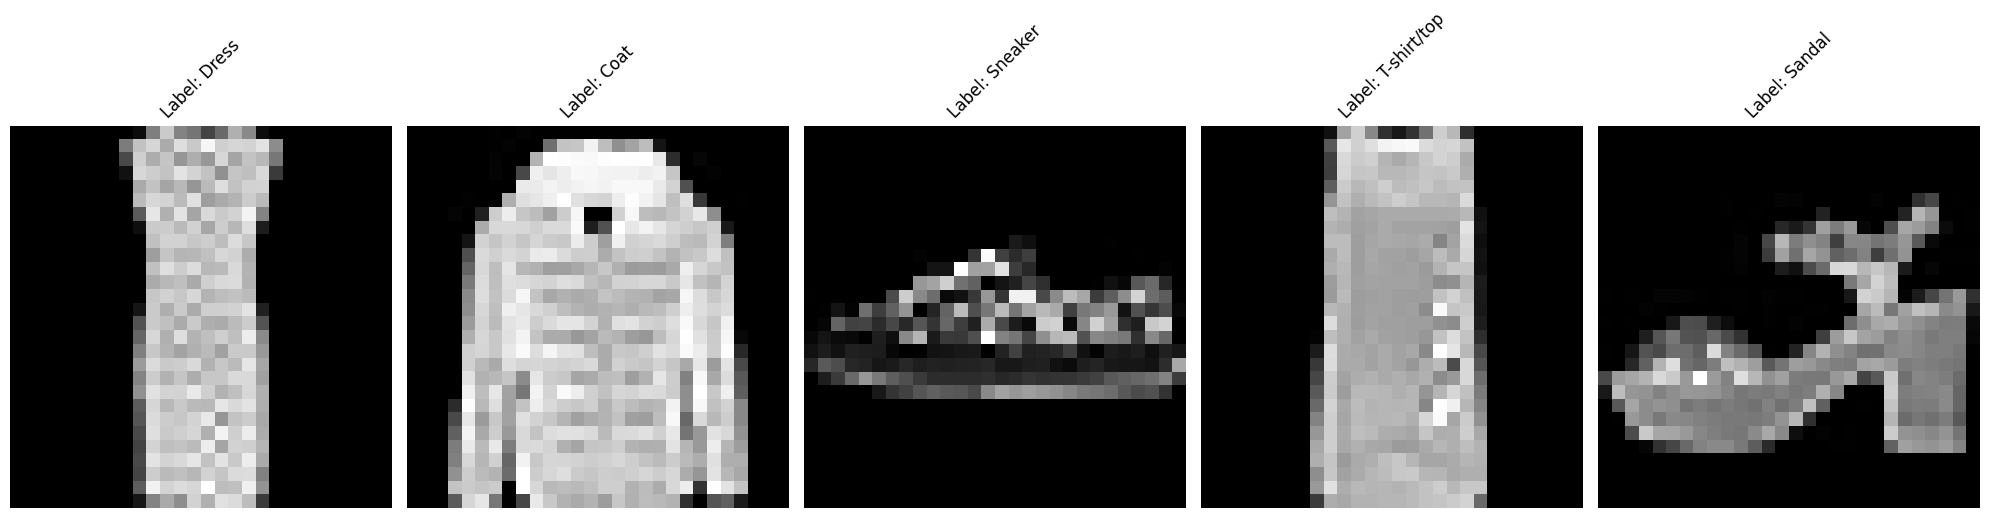

In [61]:
display_dataset_examples(trainset) # print de 5 exemplos do conj de treinamento

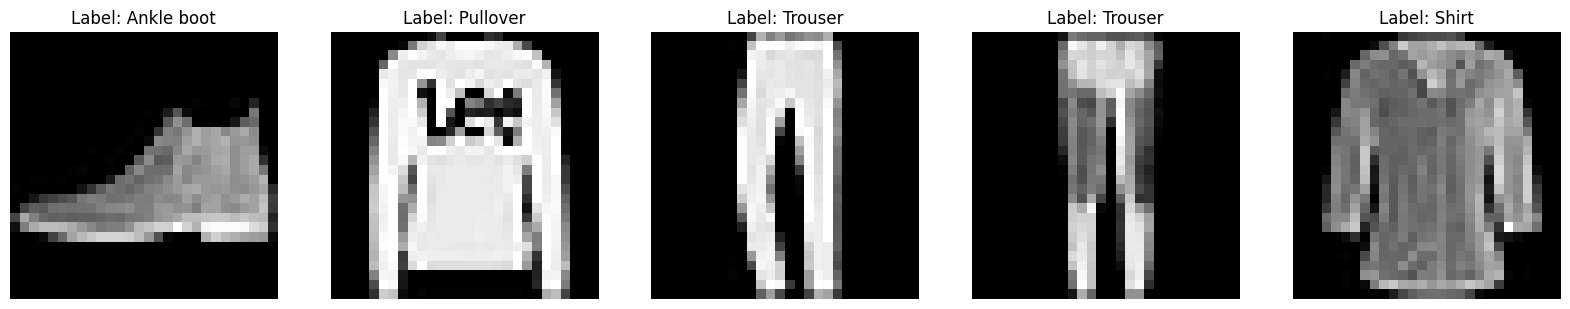

In [51]:
display_dataset_examples(testset) #  print de 5 exemplos do conj de teste

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device # colocando pra usar a gpu

device(type='cuda')

In [10]:
class DataLoader:
    # Aqui, estamos utilizando a classe DataLoader do PyTorch (torch.utils.data.DataLoader)
    # para criar um carregador de dados. Esse carregador divide o dataset em lotes 
    def __init__(self, dataset, batch_size):
        self.data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def get_data_loader(self):
        return self.data_loader

In [11]:
trainloader = DataLoader(trainset, config.get('batch_size')).get_data_loader()
valloader = DataLoader(valset, config.get('batch_size')).get_data_loader()
testloader = DataLoader(testset,config.get('batch_size')).get_data_loader()

In [12]:
class FashionMNISTModel(nn.Module):
    def __init__(self, channels, kernels, linear_units):
        super().__init__()
        self.conv1 = nn.Conv2d(channels[0], channels[1], kernel_size=kernels[0])
        self.conv2 = nn.Conv2d(channels[1], channels[2], kernel_size=kernels[1])
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(channels[2] * 4 * 4, linear_units[0])
        self.fc2 = nn.Linear(linear_units[0], linear_units[1])

    def forward(self, x):
        # passa pela primeira camada convolucional
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)

        # passa pela segunda e faz um dropout
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)

        # redimensiona o tensor para passar pela camada conectada
        x = x.view(-1, self.fc1.in_features)

        # camada conectada
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        # Aplica log_softmax para obter as probabilidades logarítmicas
        return torch.log_softmax(x, dim=1)


In [13]:
channels = [1, 10, 20] 
kernels = [5, 5]
linear_units = [50, 10]

model = FashionMNISTModel(channels, kernels, linear_units).to(device)
model

FashionMNISTModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [14]:
class Trainer:
    def __init__(self, model, device, criterion, optimizer, train_loader, val_loader):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader  # Recebe o val_loader

    def train(self, num_epochs):
        n_total_steps = len(self.train_loader)
        for epoch in range(num_epochs):
            # Inicializa a perda total para cada época
            train_loss = 0.0
            self.model.train()  # Coloca o modelo em modo de treinamento

            for i, (images, labels) in enumerate(self.train_loader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward 
                outputs = self.model(images)

                # Calcular perda
                loss = self.criterion(outputs, labels)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()

                # Atualizar os pesos
                self.optimizer.step()

                # Acumula a perda para cálculo médio
                train_loss += loss.item()

                # Log de progresso
                if (i + 1) % 100 == 0:
                    print(
                        f"Epoch [{epoch + 1}/{num_epochs}], Passo [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}"
                    )

            # Calcula a média da perda no treinamento para a época
            train_loss /= n_total_steps
            print(f"Treinamento - Epoch [{epoch + 1}/{num_epochs}], Perda: {train_loss:.4f}")

            # Avalia a perda na base de validação
            val_loss = self.validate()  # Usa val_loader aqui
            print(f"Validação - Epoch [{epoch + 1}/{num_epochs}], Perda: {val_loss:.4f}")

    def validate(self):
        self.model.eval()  # Coloca o modelo em modo de avaliação
        val_loss = 0.0
        n_samples = 0

        with torch.no_grad():  # Desativa o cálculo de gradientes para acelerar a avaliação
            for images, labels in self.val_loader:  # Usa o val_loader aqui
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward 
                outputs = self.model(images)

                # Calcular a perda na validação
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                n_samples += 1

        # Calcula a média da perda na validação
        val_loss /= n_samples
        return val_loss


In [15]:
criterion = nn.CrossEntropyLoss() # aqui são as funções de perda e o otimizador usado: adam
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

In [17]:
trainer = Trainer(model, device, criterion, optimizer, trainloader, testloader)
# instanciei o treinamento do modelo

In [18]:
trainer.train(config['num_epochs'])

Epoch [1/20], Passo [100/480], Loss: 0.7091
Epoch [1/20], Passo [200/480], Loss: 0.7896
Epoch [1/20], Passo [300/480], Loss: 0.5709
Epoch [1/20], Passo [400/480], Loss: 0.5380
Treinamento - Epoch [1/20], Perda: 0.7622
Validação - Epoch [1/20], Perda: 0.5338
Epoch [2/20], Passo [100/480], Loss: 0.8175
Epoch [2/20], Passo [200/480], Loss: 0.5294
Epoch [2/20], Passo [300/480], Loss: 0.4814
Epoch [2/20], Passo [400/480], Loss: 0.5451
Treinamento - Epoch [2/20], Perda: 0.5206
Validação - Epoch [2/20], Perda: 0.4471
Epoch [3/20], Passo [100/480], Loss: 0.4476
Epoch [3/20], Passo [200/480], Loss: 0.5278
Epoch [3/20], Passo [300/480], Loss: 0.4223
Epoch [3/20], Passo [400/480], Loss: 0.4093
Treinamento - Epoch [3/20], Perda: 0.4633
Validação - Epoch [3/20], Perda: 0.3968
Epoch [4/20], Passo [100/480], Loss: 0.5346
Epoch [4/20], Passo [200/480], Loss: 0.3902
Epoch [4/20], Passo [300/480], Loss: 0.3506
Epoch [4/20], Passo [400/480], Loss: 0.3234
Treinamento - Epoch [4/20], Perda: 0.4298
Validaçã

In [43]:
from sklearn.metrics import accuracy_score
def plot_confusion_matrix(y_true, y_pred):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    cm = confusion_matrix(y_true, y_pred)

    acc = accuracy_score(y_true, y_pred)

    # Visualiza a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix\nAcuracia:{acc}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)  
    plt.yticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

    return cm

In [ ]:
def make_predictions(model, test_loader, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_preds = []  # Armazena todas as previsões
    all_labels = []  # Armazena todos os rótulos
    with torch.no_grad():  # Desativa o cálculo de gradientes para acelerar a avaliação
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass (inference)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Obtém as previsões

            # Armazena as previsões e os rótulos
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


In [ ]:
def plot_predictions(y_true, y_pred, loader):

    
    # Classes do dataset
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # Índices das previsões corretas e incorretas
    correct_idx = np.where(y_pred == y_true)[0]
    incorrect_idx = np.where(y_pred != y_true)[0]

    # Configurações do plot
    fig, axs = plt.subplots(2, 10, figsize=(25, 6))
    axs = axs.flatten()

    # Carregue os dados do loader
    images, labels = next(iter(loader))
    
    # Certifique-se de que as imagens estão no formato correto
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()

    # Plote as imagens em que a previsão foi correta (linha 0)
    for i in range(10):
        if i < len(correct_idx):  # Verifica se há imagens suficientes
            idx = correct_idx[i]
            img, label = images[idx], labels[idx]
            axs[i].imshow(img.squeeze(), cmap='gray')
            axs[i].set_title(f'Verdadeiro: {classes[label]}\nPrevisão: {classes[y_pred[idx]]}', fontsize=9)
            axs[i].axis('off')

    # Plote as imagens em que a previsão foi incorreta (linha 1)
    for i in range(10):
        if i < len(incorrect_idx):  # Verifica se há imagens suficientes
            idx = incorrect_idx[i]
            img, label = images[idx], labels[idx]
            axs[i + 10].imshow(img.squeeze(), cmap='gray')
            axs[i + 10].set_title(f'Verdadeiro: {classes[label]}\nPrevisão: {classes[y_pred[idx]]}', fontsize=9)
            axs[i + 10].axis('off')

    plt.tight_layout()
    plt.show()


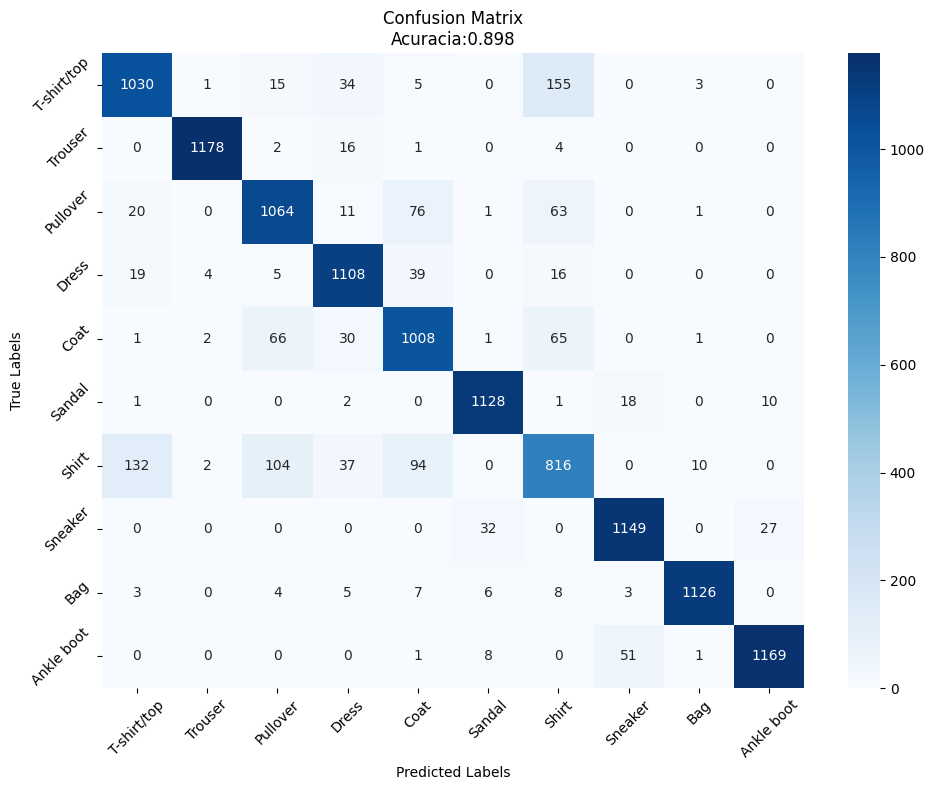

In [72]:
y_pred, y_true = make_predictions(model, valloader, device)

cm = plot_confusion_matrix(y_true,y_pred)


In [83]:
cr = classification_report(y_true,y_pred)
print(cr)

print(f'A media do f1 foi: {f1_score(y_true,y_pred,average="weighted")}')

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1243
           1       0.99      0.98      0.99      1201
           2       0.84      0.86      0.85      1236
           3       0.89      0.93      0.91      1191
           4       0.82      0.86      0.84      1174
           5       0.96      0.97      0.97      1160
           6       0.72      0.68      0.70      1195
           7       0.94      0.95      0.95      1208
           8       0.99      0.97      0.98      1162
           9       0.97      0.95      0.96      1230

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000

A media do f1 foi: 0.897635540810694


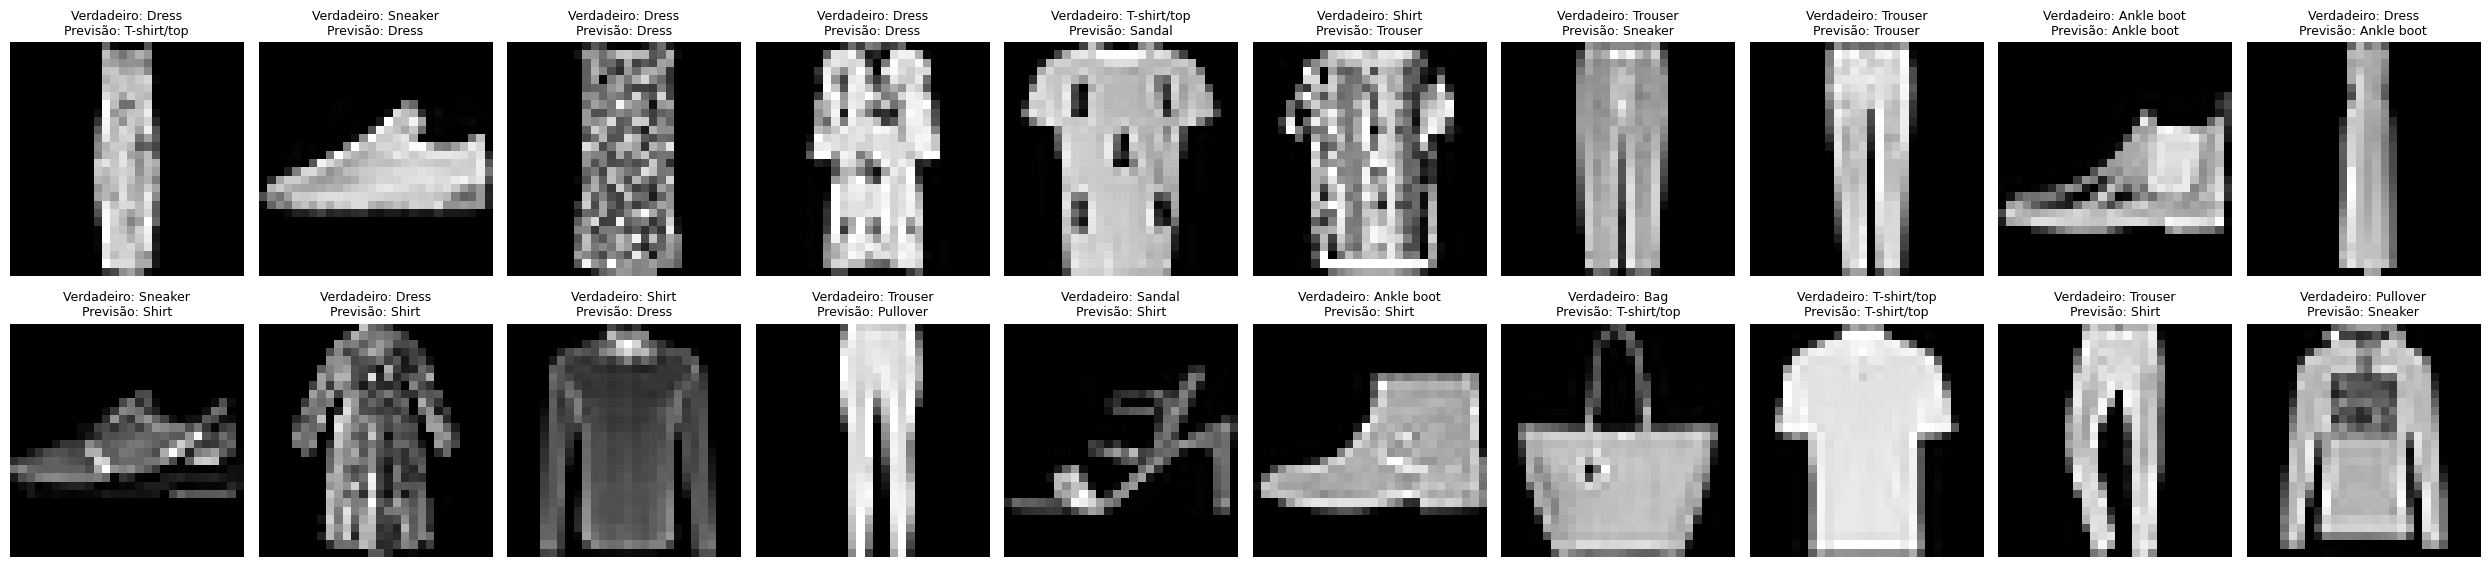

In [62]:
plot_predictions(y_true, y_pred, valloader)

Só comparando com os casos reais

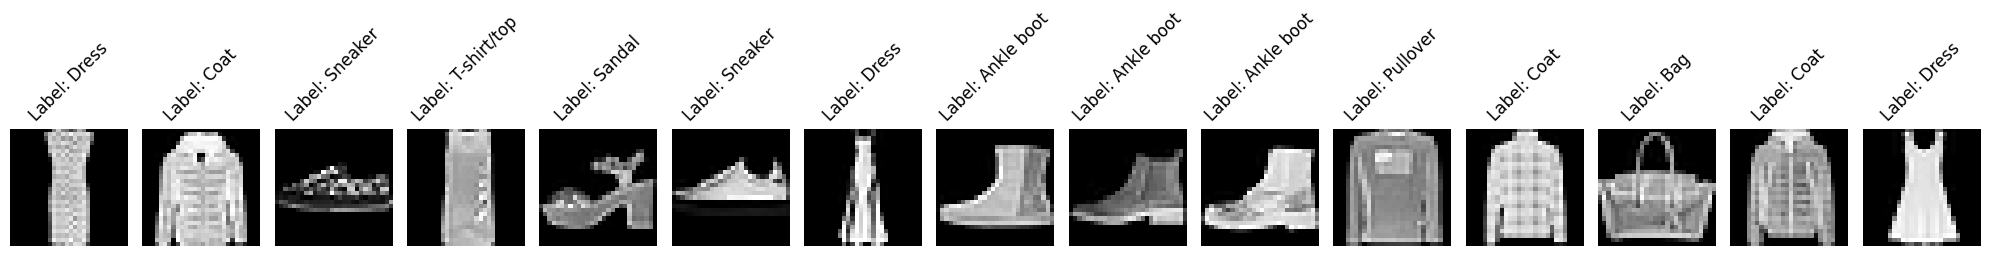

In [63]:
display_dataset_examples(trainset,15)

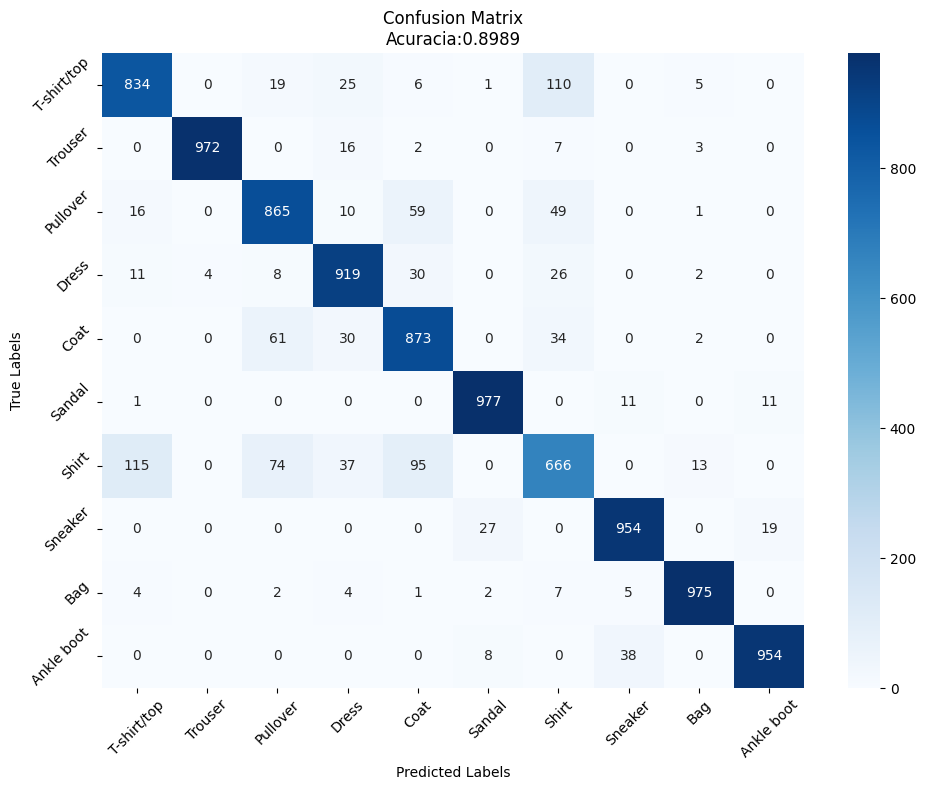

In [86]:
# Realizar as inferências
y_pred, y_true = make_predictions(model, testloader, device)

# Gerar a matriz de confusão
conf_matrix = plot_confusion_matrix(y_true, y_pred)

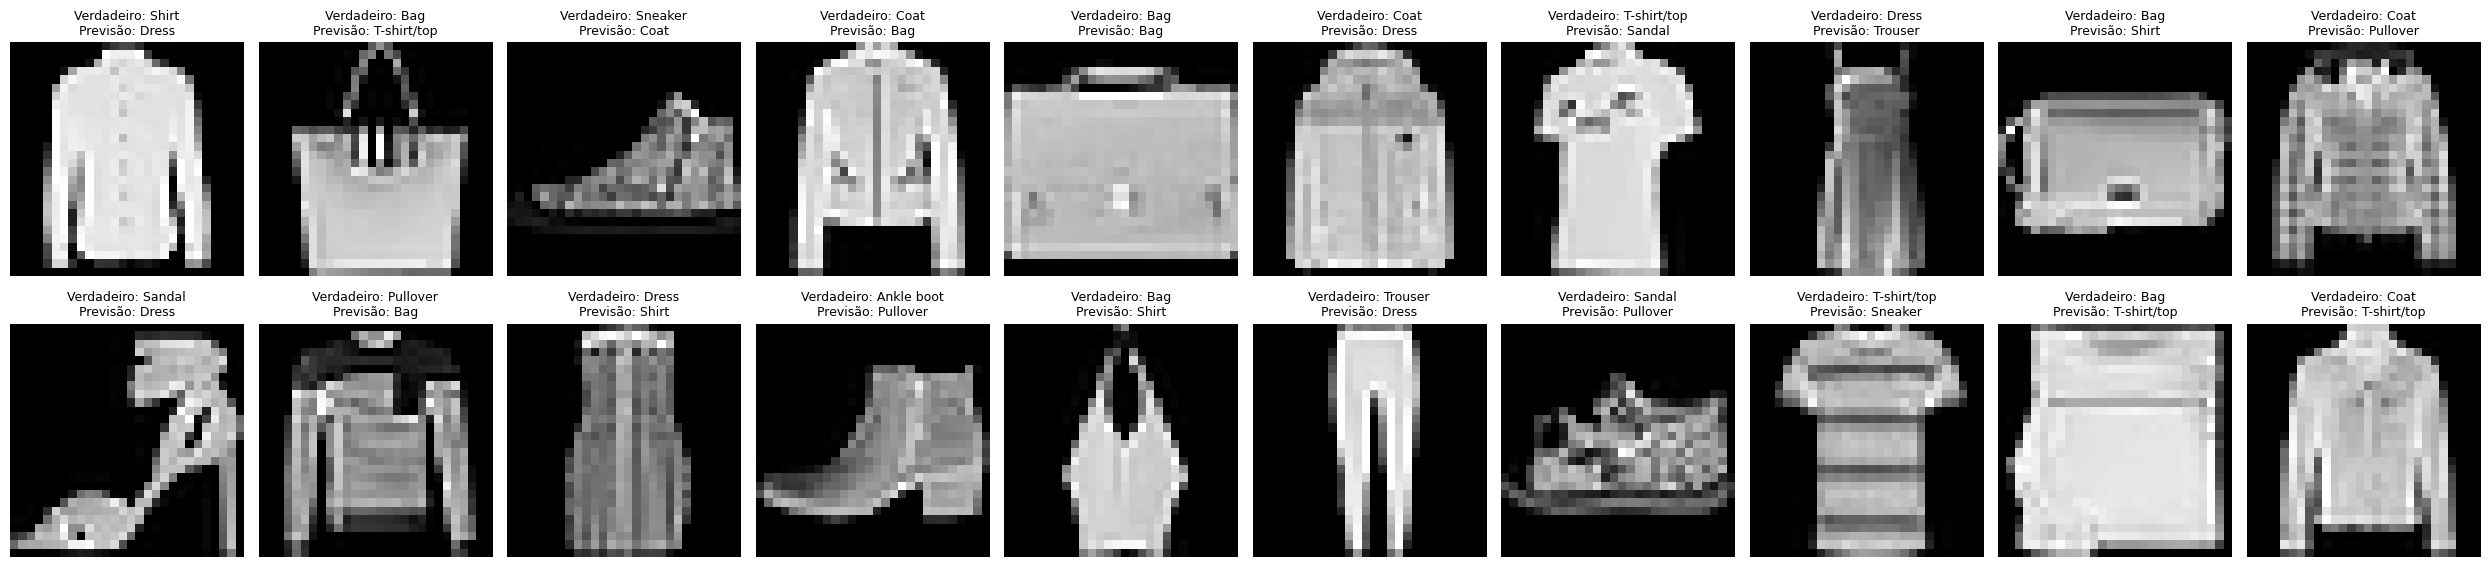

In [87]:
plot_predictions(y_true, y_pred, testloader)

In [88]:
cr = classification_report(y_true,y_pred)
print(cr)
print(f'A media do f1 foi: {f1_score(y_true,y_pred,average="weighted")}')

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       1.00      0.97      0.98      1000
           2       0.84      0.86      0.85      1000
           3       0.88      0.92      0.90      1000
           4       0.82      0.87      0.85      1000
           5       0.96      0.98      0.97      1000
           6       0.74      0.67      0.70      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

A media do f1 foi: 0.8981646046330752
